# Examining how geospatial data can help improve predicting housing prices
Group 9 - Julius Løve Fischer, Hans Chirstian Jul Lehmann & Kerem Yapici

## Importing packages and unzipping data from boliga.dk

In [1]:
import pandas as pd
import numpy as np
from numpy import NaN
#import requests
from datetime import date
#import time
#import math
#import os
#import ast
#import json
import matplotlib.pyplot as plt
#import tqdm
import seaborn as sns
#import folium
#import geopandas as gpd
#import fiona
#from shapely.geometry import Point
%matplotlib inline

In [2]:
# Saving the merged file - will use this from now on
#path = r'C:\Users\Kerem\Desktop'

#boliga.to_csv(path +'/boliga.csv')

In [3]:
boliga = pd.read_csv(r'C:\Users\Kerem\Desktop' + '/boliga.csv')

In [4]:
pd.set_option('display.max_columns', None)

# getting a overview of data
boliga.describe()

# Column type
boliga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88786 entries, 0 to 88785
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               88786 non-null  int64  
 1   address                  88786 non-null  object 
 2   zipCode                  88786 non-null  int64  
 3   price                    88786 non-null  int64  
 4   propertyType             88786 non-null  int64  
 5   saleType                 88786 non-null  object 
 6   sqmPrice                 88786 non-null  float64
 7   rooms                    88786 non-null  float64
 8   size                     88786 non-null  int64  
 9   buildYear                88786 non-null  int64  
 10  latitude                 88786 non-null  float64
 11  longitude                88786 non-null  float64
 12  municipalityCode         88786 non-null  int64  
 13  city                     88786 non-null  object 
 14  unitId                

## Data cleaning

In [5]:
# converting column types automatically
boliga.convert_dtypes().dtypes

# removing duplicate columns
boliga = boliga.drop(columns=['roomsQuantity.1']).copy()


In [7]:
pd.set_option('display.max_rows', 100)

# replacing '-' with np.NaN
boliga.replace('-', np.NaN, inplace=True)

# This way, we can count the number of missing values per column;
boliga.isnull().sum() 

# as a share of total
share = boliga.isnull().sum(axis=0) * 100 / len(boliga)

# dropping columns with NaN share of >=20%
list = ['Unnamed: 0', 'heatingCode', 'energyCode', 'heatingInstallationCode', 'heatingSecondaryCode', 'usageCode']

#other non-relevant columns
non_relevant = ['area', 'areaBusiness','areaClosedCovered','areaLiving','areaOpenCovered','areaOther',
'areaRecorded', 'appliance', 'areaSocial', 'areaUnit','basementSize','notes','propertyCondemned', 'propertyTypeName', 'propertyUnitType', 'roomsBusinessQuantity','toiletCode', 'size']

# extending list with non-relevant
list.extend(non_relevant)

# dropping lists
boliga = boliga.drop(columns=list)


<function matplotlib.pyplot.show(close=None, block=None)>

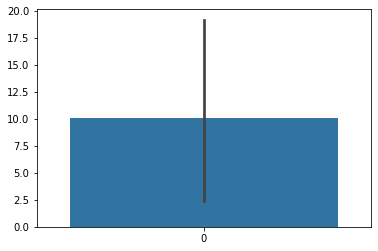

In [36]:
sns.barplot(data=share)
plt.show

In [30]:
boliga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88786 entries, 0 to 88785
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address             88786 non-null  object 
 1   zipCode             88786 non-null  int64  
 2   price               88786 non-null  int64  
 3   propertyType        88786 non-null  int64  
 4   saleType            88786 non-null  object 
 5   sqmPrice            88786 non-null  float64
 6   rooms               88786 non-null  float64
 7   buildYear           88786 non-null  int64  
 8   latitude            88786 non-null  float64
 9   longitude           88786 non-null  float64
 10  municipalityCode    88786 non-null  int64  
 11  city                88786 non-null  object 
 12  unitId              88786 non-null  object 
 13  addressFloor        74369 non-null  float64
 14  ejendomsværdiskat   88786 non-null  float64
 15  grundskyld          88786 non-null  float64
 16  buil

In [ ]:
# checking relevant variables for zero value 

boliga['bathroomQuantity'].unique()

# dropping columns with 0 values    
boliga = boliga.loc[(boliga[['buildYear', 'ejendomsværdiskat','grundskyld', 'monthlyPropertyTax', 'toiletQuantity', 'bathroomQuantity']] != 0).all(axis=1)].reset_index(drop=True)


In [28]:
pd.DataFrame(boliga.columns).to_latex(column_format='lcccc')

boliga['propertyType'].unique()

array([3, 1, 2], dtype=int64)

## Outliers

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
boliga[['sqmPrice']].describe()

print(boliga[['sqmPrice']].describe().to_latex(index=True))

\begin{tabular}{lr}
\toprule
{} &   sqmPrice \\
\midrule
count &   70312.00 \\
mean  &   37644.64 \\
std   &   26628.60 \\
min   &     182.14 \\
25\%   &   26813.02 \\
50\%   &   36137.49 \\
75\%   &   45928.99 \\
max   & 4730769.00 \\
\bottomrule
\end{tabular}



In [ ]:
print(boliga.describe())

       zipCode        price  propertyType   sqmPrice    rooms     size  \
count 70312.00     70312.00      70312.00   70312.00 70312.00 70312.00   
mean   2215.60   3651294.08          2.71   37644.64     3.30    97.08   
std     344.36   2632192.90          0.66   26628.60     1.46    43.27   
min    1050.00     14025.00          1.00     182.14     1.00    22.00   
25%    2000.00   2050000.00          3.00   26813.02     2.00    64.00   
50%    2300.00   3100000.00          3.00   36137.49     3.00    90.00   
75%    2450.00   4519895.00          3.00   45928.99     4.00   119.00   
max    2900.00 123000000.00          3.00 4730769.00    35.00   971.00   

       buildYear  latitude  longitude  municipalityCode  addressFloor  \
count   70312.00  70312.00   70312.00          70312.00      57363.00   
mean     1944.25     55.68      12.55            108.39          2.22   
std        43.92      0.02       0.04             16.89          1.90   
min      1623.00     55.62      12.45    

C:\Users\Kerem\AppData\Local\Temp\ipykernel_22172\3492731009.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boliga['sqmPrice_log'] = np.log(boliga['sqmPrice'])


<function matplotlib.pyplot.show(close=None, block=None)>

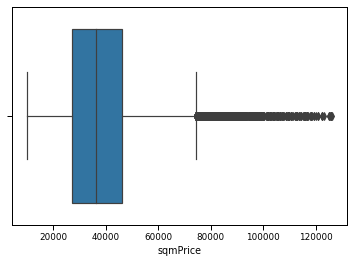

In [ ]:
# checking sqmprice
boliga = boliga.loc[(boliga['sqmPrice']<=126000) & (boliga['sqmPrice']>=10000)]

#boliga[['sqmPrice']].describe()

# taking log
boliga['sqmPrice_log'] = np.log(boliga['sqmPrice'])

# plotting
sns.boxplot(x=boliga['sqmPrice'])
plt.show

c:\Users\Kerem\anaconda3\envs\isds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Kerem\anaconda3\envs\isds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

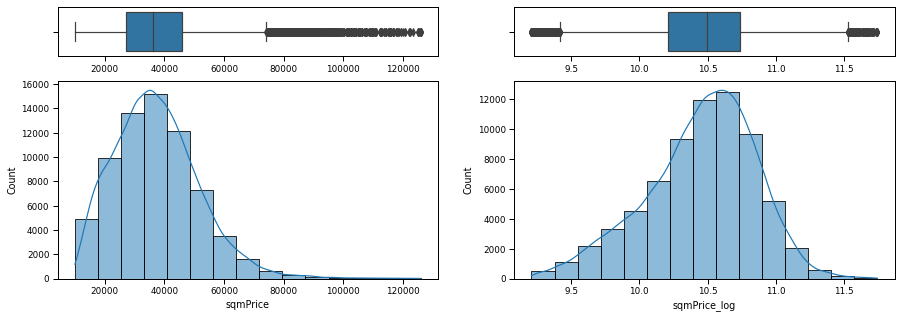

In [ ]:
sns.despine()
sns.set_context("paper")
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
fig, (ax_box, ax_hist) = plt.subplots(2,2, sharex=False, gridspec_kw={"height_ratios": (.20, .80),}, figsize=(15,5))

# assigning a graph to each ax
sns.boxplot(boliga['sqmPrice'], ax=ax_box[0]).set(xlabel=None)
sns.boxplot(boliga['sqmPrice_log'], ax=ax_box[1]).set(xlabel=None)

sns.histplot(data=boliga['sqmPrice'], bins=15, kde=True, ax=ax_hist[0])
sns.histplot(data=boliga['sqmPrice_log'], bins=15, kde=True, ax=ax_hist[1])
plt.savefig('box_hist_sqmPrices.png', bbox_inches="tight")

## Descriptive analysis